In [1]:
# lr=0.001
from tensorflow import keras
#keras.applications.densenet.DenseNet121(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
from tensorflow.keras.applications.densenet import DenseNet121
#from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Activation

def Densenet121(show_layers,weights,input_shape):
        base_model = DenseNet121(include_top=False, weights=weights, input_shape=input_shape)
        x = GlobalAveragePooling2D()(base_model.output)
        pred = Dense(1, activation='sigmoid')(x)
    
        model = Model(inputs=base_model.input, outputs=pred)
        model.compile(optimizer=SGD(lr=1e-3, decay=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
        if show_layers:
            for i, layer in enumerate(model.layers):
                print(i, layer.name, layer.trainable)
        return model
    
model = Densenet121(False,weights=None,input_shape=(224, 224, 3))

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

- train

>>  REPLAY-ATTACK
============================================Densenet121=============================================
Found 92934 images belonging to 2 classes.
Found 92975 images belonging to 2 classes.
train shape : (92934,)
Epoch 1/100


C:\Users\prlab\anaconda3\envs\ysg\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


11616/11617 [============================>.] - ETA: 0s - loss: 0.0728 - accuracy: 0.9790
Epoch 00001: val_loss improved from inf to 0.98083, saving model to .\result_cuda\REPLAY-ATTACK-01-0.9808.hdf5
11617/11617 [==============================] - 5599s 482ms/step - loss: 0.0728 - accuracy: 0.9790 - val_loss: 0.9808 - val_accuracy: 0.8685
Epoch 2/100
11616/11617 [============================>.] - ETA: 0s - loss: 0.0146 - accuracy: 0.9974
Epoch 00002: val_loss improved from 0.98083 to 0.22280, saving model to .\result_cuda\REPLAY-ATTACK-02-0.2228.hdf5
11617/11617 [==============================] - 5566s 479ms/step - loss: 0.0146 - accuracy: 0.9974 - val_loss: 0.2228 - val_accuracy: 0.9562
Epoch 3/100
11616/11617 [============================>.] - ETA: 0s - loss: 0.0083 - accuracy: 0.9985
Epoch 00003: val_loss did not improve from 0.22280
11617/11617 [==============================] - 5645s 486ms/step - loss: 0.0083 - accuracy: 0.9985 - val_loss: 0.3474 - val_accuracy: 0.9568
Epoch 4/100


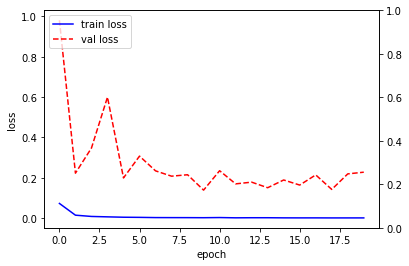

acc: 0.9830	loss: 0.1388
=======================================REPLAY-ATTACK finished=======================================


In [2]:
#### import glob
import os
import numpy as np
import cv2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 8
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\soeui\\cropped'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'REPLAY-ATTACK'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'REPLAY-ATTACK'
    
    saveDir =  '.\\result_cuda'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('Densenet121'.center(100, '='))
   
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = Densenet121(False,weights=None,input_shape=(224, 224, 3))

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)#이미지augmentation > 이미지를 회전,확대,축소 등 여러변형해보는것.
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir,trainDB,'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, validDB,'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)

    print('train shape :',train_generator.classes.shape)
    # unbalanced class를 해결하기 위한 class_weight 설정 #np.unique는 중복원소제거하는거
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes) 

    # callback 함수 정의 dropout함수
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_accuracy'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

- test

In [4]:
# 학습된 모델 테스트셋에서 성능 평가
# 얼굴 스푸핑 분야에서 평가 metric으로 HTER이랑 EER 두 개 주로 사용
# =========================================

import os
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight


%matplotlib inline

def main():
    inputSize = 224
    batchSize = 16
    
    trainDB = 'REPLAY-ATTACK'
    testDB = 'REPLAY-ATTACK'
    
    dataDir = 'C:\\Users\\prlab\\Desktop\\soeui\\cropped'
    modelPath = 'F:\\prlab\\ysg\\densenet-spoofing\\result_cuda\\REPLAY-ATTACK_batch16-14-0.0106.hdf5'
    
    print('>> model loaded: {}'.format(os.path.basename(modelPath)))
    K.clear_session()
    model = load_model(modelPath)
        
    print(">>>> evaluating on '{}'".format(testDB))
    test_datagen = ImageDataGenerator()

    val_datagen = ImageDataGenerator()
    
    val_datagen = ImageDataGenerator(rescale=1.0/255.0)
    val_generator = val_datagen.flow_from_directory(os.path.join(*[dataDir, testDB, 'val']),
                                                      target_size=(inputSize, inputSize),
                                                      batch_size=batchSize,
                                                      class_mode='binary',
                                                      interpolation='bilinear',
                                                      shuffle=False,)
    
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    test_generator = test_datagen.flow_from_directory(os.path.join(*[dataDir, testDB, 'test']),
                                                      target_size=(inputSize, inputSize),
                                                      batch_size=batchSize,
                                                      class_mode='binary',
                                                      interpolation='bilinear',
                                                      shuffle=False,)

    ''' evaluate test'''
    loss_and_metrics = model.evaluate_generator(test_generator,steps=len(test_generator))
    print('## evaluation loss and_metrics ##')
    print(loss_and_metrics)
    
    ''' evaluating EER '''
    y_true = val_generator.classes
    #시작
    y_score = model.predict_generator(val_generator, steps=len(val_generator)).ravel()
    # 종료
    fpr, tpr, threshold = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr-fpr)))]
    val_eer = (fpr[np.nanargmin(np.absolute((fnr - fpr)))] + fnr[np.nanargmin(np.absolute((fnr - fpr)))]) / 2

    ''' evaluating HTER '''
    y_true = test_generator.classes
    y_score = model.predict_generator(test_generator, steps = len(test_generator)).ravel()

    # Calculate EER threshold
    fpr, tpr, threshold = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr-fpr)))]

    # HTER
    y_pred = y_score > eer_threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    labels = test_generator.class_indices
    print('                  pred_fake({})   pred_real({})\nactural_fake({})    {:12d}   {:12d}\nactual_real({})    {:12d}   {:12d}\n'.format(labels['fake'], labels['real'], labels['fake'], tn, fp, labels['real'], fn, tp))
    hter = (fp/(tn+fp) + fn/(fn+tp)) * 0.5

    # ROC curve
    Accuracy = ((tn+tp) / (tn+fp+fn+tp)) * 100.0

    roc_auc = roc_auc_score(y_true, y_score)

    plt.figure()
    lw = 2

    plt.plot(fpr, tpr, 'r--', label='ROC_curve (acc_1st = %0.2f%%)' % Accuracy)
    plt.plot([0, 1], [1, 0], label='EER_line', color = 'orange', lw=lw, linestyle='--')

    #plt.xlim([0.00, 1.0])
    #plt.ylim([0.75, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = "lower right")

    #plt.savefig('protocol_4_001.png')
    plt.figure()
    
    print('EER: {:.4f}\tHTER: {:.4f}'.format(val_eer, hter))

    print('>> finished')

        
if __name__ == '__main__':
    start=time.time()
    main()
    print("time : ",time.time()-start)

>> model loaded: REPLAY-ATTACK_batch16-14-0.0106.hdf5


KeyboardInterrupt: 